In [1]:
import sys
sys.path.append('..')
from helpers import util
import cv2
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import scipy.spatial


In [2]:
# format 4x3 [origin,xaxis,yaxis,zaxis]
def plot_as_axes(ax,three_pts):
    ax.plot(three_pts[[0,1],0],three_pts[[0,1],1],three_pts[[0,1],2],label = 'x')
    ax.plot(three_pts[[0,2],0],three_pts[[0,2],1],three_pts[[0,2],2],label = 'y')
    ax.plot(three_pts[[0,3],0],three_pts[[0,3],1],three_pts[[0,3],2],label = 'z')

def get_cam_rot_t(in_dir, cell_num, cam_range, im_num = None):
    to_ret = []
    for cam in cam_range:
        vals_file = [cell_num,cam]
        if im_num is not None:
            vals_file.append(im_num)
#         print (vals_file)
        in_file = os.path.join(in_dir, '_'.join(vals_file)+'.npz')
        if not os.path.exists(in_file):
            continue
#         print (in_file, os.path.exists(in_file))
        loaded = np.load(in_file)
        [rvec, tvec] = [loaded[key] for key in ['rvec','tvec']]
        rot, jacob = cv2.Rodrigues(rvec)
        camera_pos = np.matmul(-rot.T,tvec) 
        to_ret.append((camera_pos, rot, tvec))
    return to_ret
        


# visualizing camera positions

In [ ]:
pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
pts = np.array(pts)
# print (pts)

in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
cell_num = ['1','2']
cam_range = [str(val) for val in range(4)]
im_num = None

# im_dir = 
in_dir = '../../data/camera_calibration_frames_try2/extrinsics'
cell_nums = ['2']
im_nums = [2976, 2947, 2662, 3047, 2953, 2605, 2674, 2655]
cam_range = [str(val) for val in [0,1,2,3]]
check_rows = 11
check_cols = 7


objp = []
for row in range(check_rows):
    for col in range(check_cols):
        objp.append([row,col, 0])
objp = np.array(objp,dtype= np.float)

for cell_num in cell_nums:
    for im_num in im_nums:
        print (cell_num, im_num)
        
        cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range, str(im_num))

        new_axis_all = []
        for cam_pos, rot, tvec in cam_rot_t:
            pts_new = (pts.T)-tvec
    #         inv = (rot - rot.T)/2.
            camera_axis = np.matmul(rot.T,pts_new).T
            camera_axis = camera_axis
            new_axis_all.append(camera_axis)

        fig = plt.figure()

        ax = fig.gca(projection='3d')
        ax.set_title(cell_num)
    #     ax.set_aspect('equal')
        plot_as_axes(ax,pts)
        for camera_axis in new_axis_all:
            plot_as_axes(ax,camera_axis)
        plt.plot(objp[:,0],objp[:,1],objp[:,2],'*b')
        ax.legend()
        plt.show()

# seeing cam and boards before and after bundling

<IPython.core.display.Javascript object>


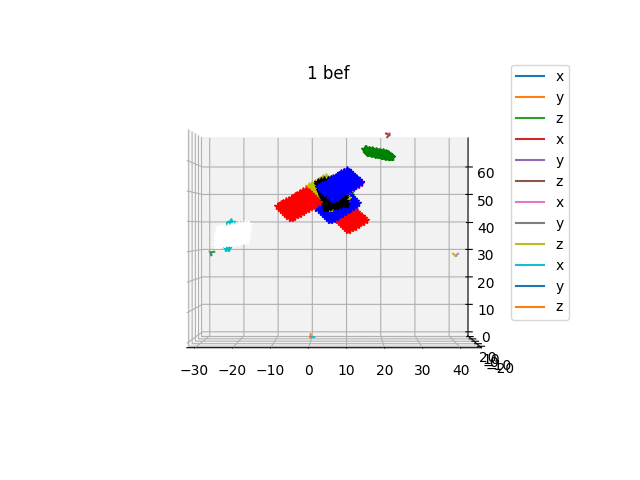

<IPython.core.display.Javascript object>


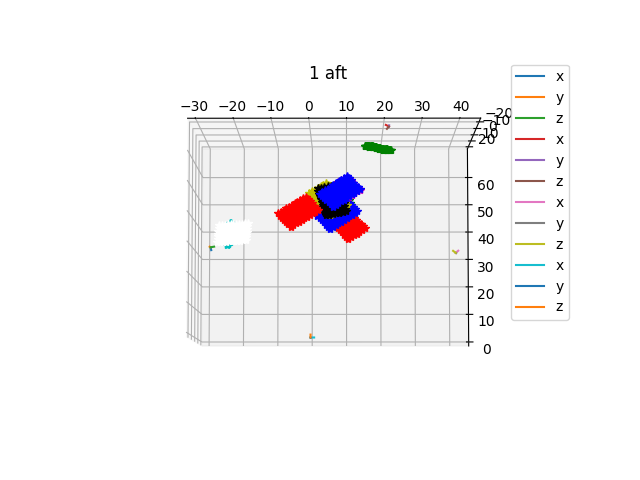

<IPython.core.display.Javascript object>


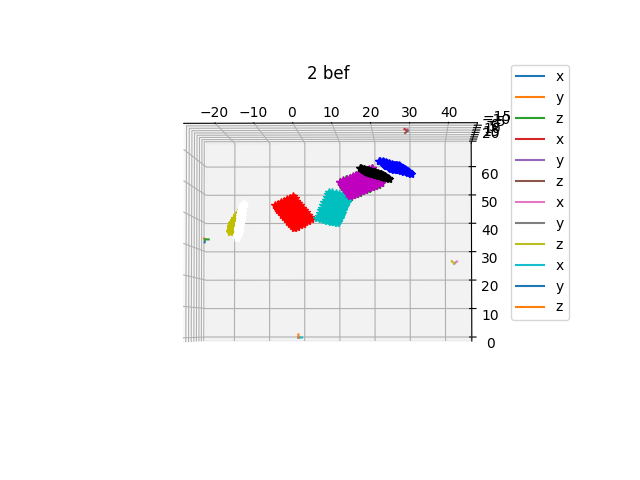

<IPython.core.display.Javascript object>


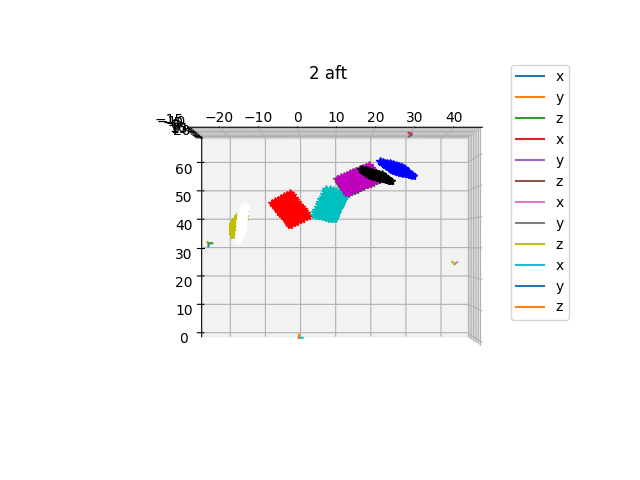

In [13]:
def viz_it_all(pts_3d, camera_params,title):
    pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
    pts = np.array(pts)
    new_axis_all = []
    for cam in camera_params:
        [rvec,tvec] = [vec[:,np.newaxis] for vec in [cam[:3],cam[3:6]]]
        rot = cv2.Rodrigues(rvec)[0]
        pts_new = (pts.T)-tvec
        camera_axis = np.matmul(rot.T,pts_new).T
        new_axis_all.append(camera_axis)
        
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_title(title)
#     ax.set_aspect('equal')
#     plot_as_axes(ax,pts)
    for camera_axis in new_axis_all:
        plot_as_axes(ax,camera_axis)
    colors = ['r','g','b','c','m','y','k','w']
    for idx,objp in enumerate(pts_3d):
        plt.plot(objp[:,0],objp[:,1],objp[:,2],'*'+colors[idx%len(colors)])
    ax.legend()
    plt.show()

# [2976, 2947, 2662, 3047, 2953, 2605, 2674, 2655]
meta_dir = '../../data/camera_calibration_frames_try2'
interval_str = '20200428104445_113700'
out_dir_dets = os.path.join(meta_dir, 'calib_im_fix_dets')
out_dir_intrinsic = os.path.join(meta_dir, 'intrinsics')
out_dir_calib =  os.path.join(meta_dir, 'extrinsics')

cell_num = 1
num_im_sets = 11
for cell_num, num_im_sets in zip([1,2],[11,8]):
    
    bef_file = os.path.join(out_dir_calib, str(cell_num)+'_bundle.npz')
    aft_file = os.path.join(out_dir_calib, str(cell_num)+'_bundle_optimized.npz')
    title_strs = [str(cell_num)+' '+val for val in ['bef','aft']]
    for idx_file_curr,file_curr in enumerate([bef_file, aft_file]):
        loaded = np.load(file_curr)
        strings = ['points_3d','camera_params']
        [points_3d, camera_params] = [loaded[key] for key in strings]
        points_3d = np.reshape(points_3d, (num_im_sets, -1, points_3d.shape[1]))
        # print points_3d.shape
        viz_it_all(points_3d, camera_params,title_strs[idx_file_curr])

# verifying cam2cam world2cam

In [ ]:
pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
pts = np.array(pts)
pts = pts.T*10
# print (pts)

in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
cell_num = '1'
cam_range = [str(val) for val in range(4)]
for cell_num in ['1','2']:
    cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range)
    
    rot_all = []
    tvecs = []
    for cam_pos, rot, tvec in cam_rot_t:
        
        rot_all.append(rot)
        tvecs.append(tvec)
    s_cam = 0
    w2cam_s = rot_all[s_cam]
    cam2w_s = w2cam_s.T
    s_w = np.matmul(cam2w_s,(pts-tvecs[s_cam]))
    pts_org = [pts, s_w]
    for t_cam in range(1,4):
        w2cam_t = rot_all[t_cam]
        cam2w_t = w2cam_t.T
        cam2cam = np.matmul(w2cam_t, cam2w_s)
        t_w = np.matmul(cam2w_t,(pts-tvecs[t_cam]))
        
        pts_all = pts_org+[t_w]
        in_cam_s= []
        for pts_curr in pts_all:
            p_p = np.matmul(w2cam_s,pts_curr)+tvecs[s_cam]
            in_cam_s.append(p_p)
        
        in_cam_t = []
        for pts_curr in in_cam_s:
            p_p = np.matmul(cam2cam,pts_curr-tvecs[s_cam])+tvecs[t_cam]
            in_cam_t.append(p_p)
        
#         check relative differences are the same
        pts_to_plot = [pts_all, in_cam_s, in_cam_t]
        for pts_bunch in pts_to_plot:
            origins = [pts_curr[:,0] for pts_curr in pts_bunch]
            origins = np.array(origins)
            dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(origins))
            print (dists)
        
        title_str = ['world','source','target']
        for idx,pts_to_plot in enumerate(pts_to_plot):
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            ax.set_title(' '.join([title_str[idx],cell_num,str(s_cam),str(t_cam)]))
            for pts_curr in pts_to_plot:
                print (pts_curr.shape)
                plot_as_axes(ax,pts_curr.T)
            ax.legend()
            plt.show()
#         break
#     break

# saving rot mats

In [ ]:
out_dir = '../../data/rotation_identity/'
cam_nums = range(1,9)
rot_strs = ['extrinsic_rot','extrinsic_rot_inv']
eye_mat = np.eye(3)
print (eye_mat)
out_files = [os.path.join(out_dir,rot_str+'_'+str(cam_num)+'.npy') for cam_num in cam_nums for rot_str in rot_strs]
# print (out_files)
for out_file in out_files:
    np.save(out_file, eye_mat)

In [ ]:

in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
out_dir = '../../data/rotation_cal_1'
view_df = pd.read_csv('../../metadata/viewpoints.csv')
print (viewpoints)
cell_num = '1'
cam_range = [str(val) for val in range(4)]
for cell_num in ['1','2']:
    cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range)
    for idx_cam,cam in enumerate(cam_range):
        cam_real = view_df.loc[view_df['subject'] == 'cell'+str(cell_num)][str(cam)].values[0]
        rot_curr = cam_rot_t[idx_cam][1]
        out_file = os.path.join(out_dir,'extrinsic_rot_'+str(cam_real)+'.npy')
#         np.save(out_file, rot_curr)
        check = np.load(out_file)
        assert np.all(rot_curr == check)

        rot_inv = rot_curr.T
        out_file = os.path.join(out_dir,'extrinsic_rot_inv_'+str(cam_real)+'.npy')
#         np.save(out_file, rot_inv)
        check = np.load(out_file)
        assert np.all(rot_inv == check) 

In [21]:
import pandas as pd
meta_dir = '../../data/camera_calibration_frames_try2'
interval_str = '20200428104445_113700'
out_dir_dets = os.path.join(meta_dir, 'calib_im_fix_dets')
out_dir_intrinsic = os.path.join(meta_dir, 'intrinsics')
out_dir_calib =  os.path.join(meta_dir, 'extrinsics')

out_dir = '../../data/rotation_cal_2'
util.mkdir(out_dir)
view_df = pd.read_csv('../../metadata/viewpoints.csv')
views = range(4)
for cell_num, num_im_sets in zip([1,2],[11,8]):
    file_curr = os.path.join(out_dir_calib, str(cell_num)+'_bundle_optimized.npz')
    loaded = np.load(file_curr)
    strings = ['points_3d','camera_params']
    [points_3d, camera_params] = [loaded[key] for key in strings]
    for view in views:
        
        cam = camera_params[view]
        [rvec,tvec] = [vec[:,np.newaxis] for vec in [cam[:3],cam[3:6]]]
        rot_curr = cv2.Rodrigues(rvec)[0]
        
        cam_real = view_df.loc[view_df['subject'] == 'cell'+str(cell_num)][str(view)].values[0]
        out_file = os.path.join(out_dir,'extrinsic_rot_'+str(cam_real)+'.npy')

        print (cell_num, view, cam_real)
#         print (out_file)
#         print (rot_curr)
#         np.save(out_file, rot_curr)
        check = np.load(out_file)
        assert np.all(rot_curr == check)

        rot_inv = rot_curr.T
        out_file = os.path.join(out_dir,'extrinsic_rot_inv_'+str(cam_real)+'.npy')
        
#         print (out_file)
#         print (rot_inv)
#         np.save(out_file, rot_inv)
        check = np.load(out_file)
        assert np.all(rot_inv == check) 
        
        out_file = os.path.join(out_dir,'extrinsic_tvec_'+str(cam_real)+'.npy')
        print (out_file)
        print (tvec.squeeze())
#         np.save(out_file, tvec.squeeze())
        check = np.load(out_file)
        assert np.all(tvec.squeeze() == check) 


1 0 2
../../data/rotation_cal_2/extrinsic_tvec_2.npy
[35.57347061 -7.07590223 20.91131054]
1 1 8
../../data/rotation_cal_2/extrinsic_tvec_8.npy
[-20.21521015 -22.07100813  68.87281225]
1 2 4
../../data/rotation_cal_2/extrinsic_tvec_4.npy
[-48.61620081  -1.23404611   9.08546294]
1 3 7
../../data/rotation_cal_2/extrinsic_tvec_7.npy
[-0. -0.  0.]
2 0 1
../../data/rotation_cal_2/extrinsic_tvec_1.npy
[32.14084188 -4.92794235 27.51631557]
2 1 3
../../data/rotation_cal_2/extrinsic_tvec_3.npy
[-16.07774258 -23.85349885  68.66196981]
2 2 5
../../data/rotation_cal_2/extrinsic_tvec_5.npy
[-47.76508658  -3.7815896    7.85650798]
2 3 6
../../data/rotation_cal_2/extrinsic_tvec_6.npy
[-0. -0.  0.]
